Descriptive Statistics:
                                         count          mean      std  \
X1 transaction date                     414.0  3.705506e-13  1.00121   
X2 house age                            414.0 -9.225042e-17  1.00121   
X3 distance to the nearest MRT station  414.0 -1.265762e-16  1.00121   
X4 number of convenience stores         414.0 -7.508755e-18  1.00121   
X5 latitude                             414.0  1.343166e-13  1.00121   
X6 longitude                            414.0 -1.614537e-12  1.00121   

                                             min       25%       50%  \
X1 transaction date                    -1.711384 -0.823683  0.064017   
X2 house age                           -1.556639 -0.763492 -0.141717   
X3 distance to the nearest MRT station -0.841279 -0.630312 -0.469349   
X4 number of convenience stores        -1.391638 -1.051734 -0.032020   
X5 latitude                            -2.981805 -0.486485  0.166994   
X6 longitude                          

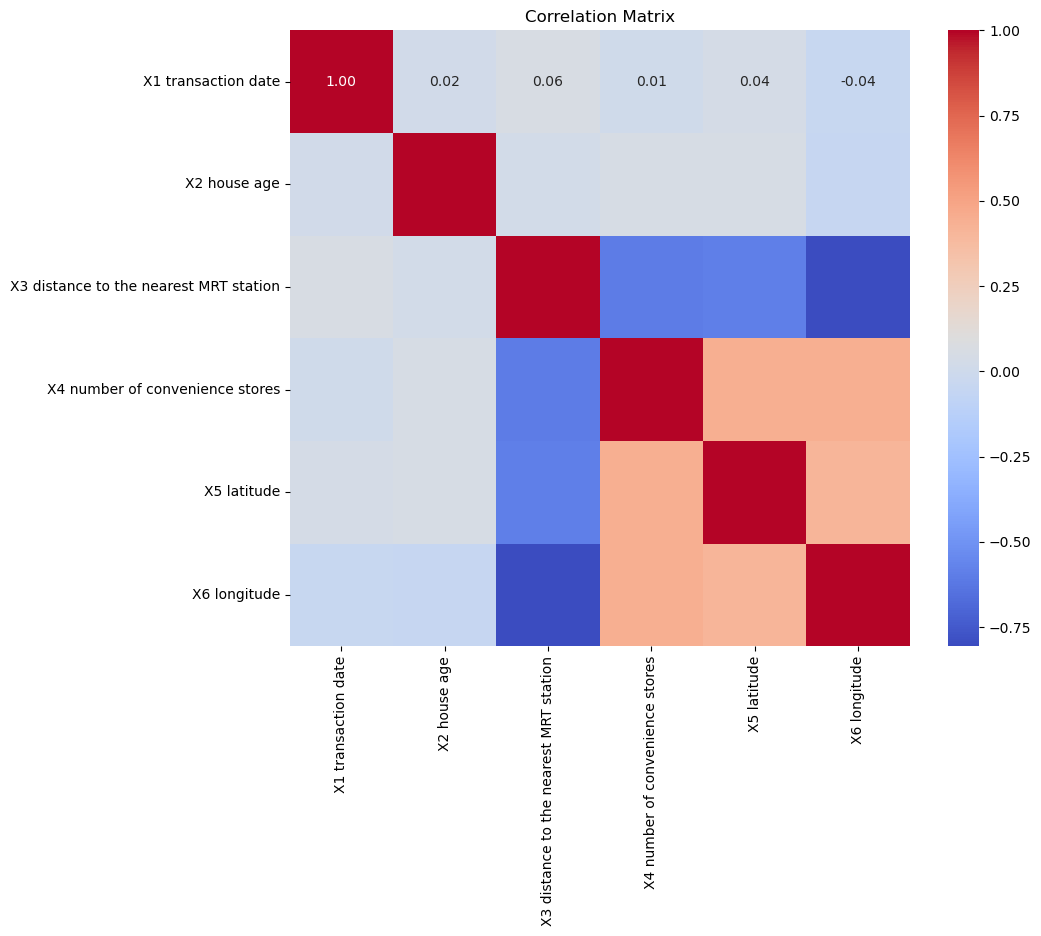

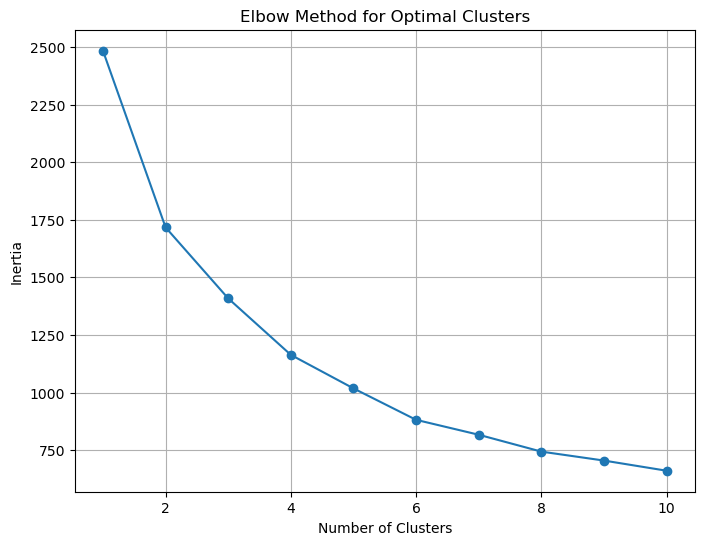

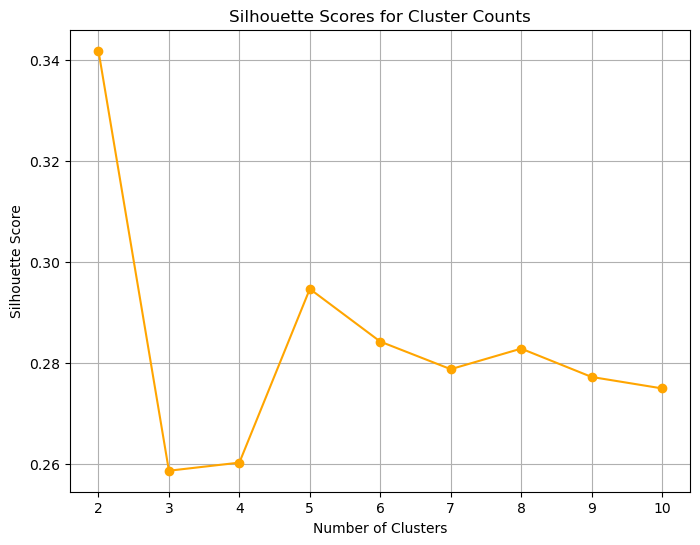

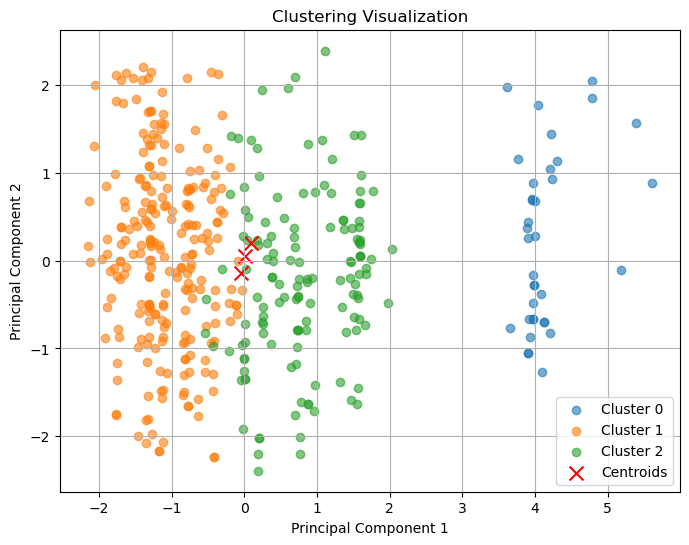

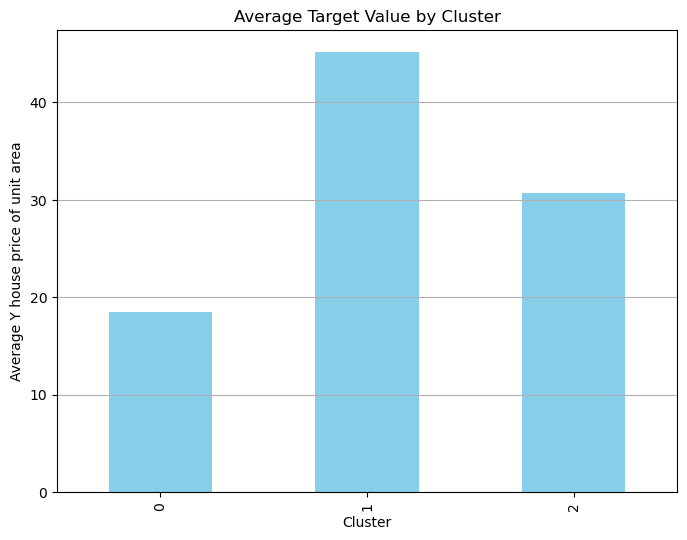

Predicted Clusters for New Data Points: [1 0 1]


/opt/anaconda3/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but KMeans was fitted with feature names
  warnings.warn(


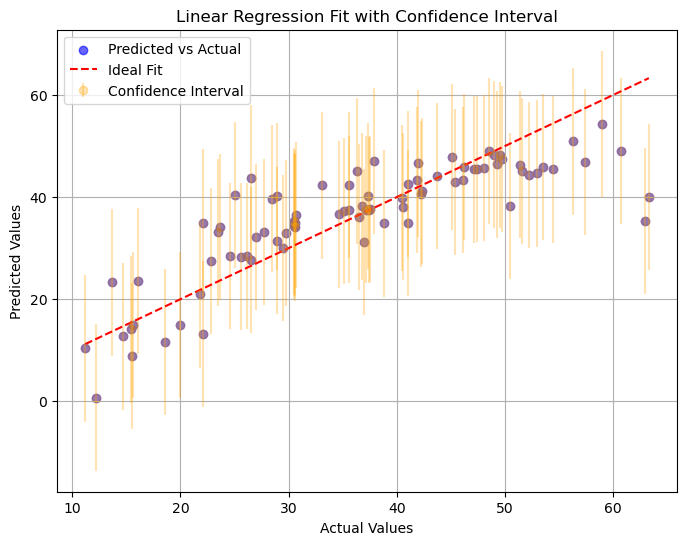

Mean Squared Error (MSE): 53.51
R-squared (R²): 0.68


In [1]:
# Import necessary libraries
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import silhouette_score, mean_squared_error, r2_score
import matplotlib.pyplot as plt
import seaborn as sns

# Load the dataset
file_path = 'Real estate.csv'  # Update the file path if needed
dataset = pd.read_csv(file_path)

# Step 1: Data Preprocessing
def preprocess_data(dataset, columns_to_normalize):
    """
    Normalize the specified numerical columns in the dataset using StandardScaler.
    """
    scaler = StandardScaler()
    dataset_normalized = dataset.copy()
    dataset_normalized[columns_to_normalize] = scaler.fit_transform(dataset[columns_to_normalize])
    return dataset_normalized

numerical_columns = ['X1 transaction date', 'X2 house age', 
                     'X3 distance to the nearest MRT station', 
                     'X4 number of convenience stores', 
                     'X5 latitude', 'X6 longitude']

normalized_data = preprocess_data(dataset, numerical_columns)

# Step 2: Statistical Depth (Descriptive Statistics and Correlation Matrix)
def compute_statistics(data, columns):
    """
    Compute descriptive statistics and correlation matrix for the dataset.
    """
    stats = data[columns].describe().T
    stats['skewness'] = data[columns].skew()
    stats['kurtosis'] = data[columns].kurt()
    
    print("Descriptive Statistics:\n", stats)
    plt.figure(figsize=(10, 8))
    sns.heatmap(data[columns].corr(), annot=True, cmap='coolwarm', fmt=".2f", cbar=True)
    plt.title('Correlation Matrix')
    plt.show()

compute_statistics(normalized_data, numerical_columns)

# Step 3: Clustering

# Elbow Method
def plot_elbow_method(data, max_clusters=10):
    """
    Plot the elbow method to determine the optimal number of clusters.
    """
    inertias = []
    for k in range(1, max_clusters + 1):
        kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
        kmeans.fit(data)
        inertias.append(kmeans.inertia_)
    
    plt.figure(figsize=(8, 6))
    plt.plot(range(1, max_clusters + 1), inertias, marker='o')
    plt.title('Elbow Method for Optimal Clusters')
    plt.xlabel('Number of Clusters')
    plt.ylabel('Inertia')
    plt.grid(True)
    plt.show()

plot_elbow_method(normalized_data[numerical_columns])

# Silhouette Score Visualization
def plot_silhouette_scores(data, max_clusters=10):
    """
    Plot silhouette scores for different cluster counts.
    """
    silhouette_scores = []
    for k in range(2, max_clusters + 1):  # Silhouette scores are only defined for k >= 2
        kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
        labels = kmeans.fit_predict(data)
        score = silhouette_score(data, labels)
        silhouette_scores.append(score)
    
    plt.figure(figsize=(8, 6))
    plt.plot(range(2, max_clusters + 1), silhouette_scores, marker='o', color='orange')
    plt.title('Silhouette Scores for Cluster Counts')
    plt.xlabel('Number of Clusters')
    plt.ylabel('Silhouette Score')
    plt.grid(True)
    plt.show()

plot_silhouette_scores(normalized_data[numerical_columns])

# Perform Clustering
def perform_kmeans_clustering(data, n_clusters):
    """
    Perform K-Means clustering and return the cluster labels and centroids.
    """
    kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
    cluster_labels = kmeans.fit_predict(data)
    return cluster_labels, kmeans.cluster_centers_

def visualize_clusters(data, cluster_labels, centroids, title="Clustering Visualization"):
    """
    Visualize clusters using PCA to reduce dimensionality to 2 components.
    """
    pca = PCA(n_components=2)
    reduced_data = pca.fit_transform(data)
    
    plt.figure(figsize=(8, 6))
    for cluster in np.unique(cluster_labels):
        cluster_points = reduced_data[cluster_labels == cluster]
        plt.scatter(cluster_points[:, 0], cluster_points[:, 1], label=f'Cluster {cluster}', alpha=0.6)
    
    plt.scatter(centroids[:, 0], centroids[:, 1], color='red', marker='x', s=100, label='Centroids')
    plt.title(title)
    plt.xlabel('Principal Component 1')
    plt.ylabel('Principal Component 2')
    plt.legend()
    plt.grid(True)
    plt.show()

optimal_clusters = 3
cluster_labels, centroids = perform_kmeans_clustering(normalized_data[numerical_columns], optimal_clusters)
visualize_clusters(normalized_data[numerical_columns], cluster_labels, centroids)

# Add a Categorical Plot
def plot_categorical_summary(data, clusters, target, title="Average Target Value by Cluster"):
    """
    Plot the average target value for each cluster.
    """
    data['Cluster'] = clusters
    cluster_summary = data.groupby('Cluster')[target].mean()
    
    plt.figure(figsize=(8, 6))
    cluster_summary.plot(kind='bar', color='skyblue')
    plt.title(title)
    plt.xlabel('Cluster')
    plt.ylabel(f'Average {target}')
    plt.grid(axis='y')
    plt.show()

plot_categorical_summary(normalized_data, cluster_labels, 'Y house price of unit area')

# Clustering Predictions for New Data
def predict_cluster(new_data, fitted_kmeans_model):
    """
    Predict the cluster for new data points using a pre-fitted KMeans model.
    """
    return fitted_kmeans_model.predict(new_data)

# Fit the KMeans model
kmeans_model = KMeans(n_clusters=optimal_clusters, random_state=42, n_init=10)
kmeans_model.fit(normalized_data[numerical_columns])

# Predict for multiple new data points
new_data_points = np.array([
    [2013, 15, 300, 8, 24.98, 121.54],
    [2012, 30, 800, 5, 24.95, 121.50],
    [2014, 10, 200, 12, 25.00, 121.60]
])
new_data_scaled = StandardScaler().fit_transform(new_data_points)
predicted_clusters = predict_cluster(new_data_scaled, kmeans_model)
print(f"Predicted Clusters for New Data Points: {predicted_clusters}")

# Step 4: Regression
def train_and_evaluate_regression(X, y):
    """
    Train a linear regression model and evaluate its performance.
    """
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    regressor = LinearRegression()
    regressor.fit(X_train, y_train)
    
    y_pred = regressor.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    
    y_pred_std = np.std(y_test - y_pred)
    confidence_interval = 1.96 * y_pred_std
    
    plt.figure(figsize=(8, 6))
    plt.scatter(y_test, y_pred, alpha=0.6, label='Predicted vs Actual', color='blue')
    plt.errorbar(y_test, y_pred, yerr=confidence_interval, fmt='o', alpha=0.3, label='Confidence Interval', color='orange')
    plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', linestyle='--', label='Ideal Fit')
    plt.title('Linear Regression Fit with Confidence Interval')
    plt.xlabel('Actual Values')
    plt.ylabel('Predicted Values')
    plt.legend()
    plt.grid(True)
    plt.show()
    
    return mse, r2

X = normalized_data[numerical_columns]
y = normalized_data['Y house price of unit area']
mse, r2 = train_and_evaluate_regression(X, y)

print(f"Mean Squared Error (MSE): {mse:.2f}")
print(f"R-squared (R²): {r2:.2f}")
